<a href="https://colab.research.google.com/github/ncerutti/colabs/blob/main/FSPD_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd

fspd_f = pd.read_stata('./data/March30_f.dta')
fspd_f.columns
print(fspd_f['segment'].unique())
print(fspd_f['segment'].isnull().sum())

['04Trade' '02Farming' '11General_framework' '01Inputs'
 '10Natural_resource_mgmt' '03Distribution_transport'
 '08Final_consumption' '09Multiple' '05Processing_manufacturing'
 '06Retail' '07Foodservice']
0


In [13]:
# create a new dataframe with only 'policydecision_details', 'segment', and 'lever' columns

df = fspd_f[['policydecision_details', 'segment']]
# check minimum and maximum length of text in 'policydecision_details' column

print(df['policydecision_details'].str.len().min())
print(df['policydecision_details'].str.len().max())
# check how many rows have len(policydecision_details) < 20

df[df['policydecision_details'].str.len() < 10].shape
# encode all segments to numeric by keeping only the first two characters

df['segment'] = df['segment'].str[:2]

# then print the unique values of the 'segment' column

print(df['segment'].unique())

# finally, print the number of rows with null values in the 'segment' column (just to be sure)

print(df['segment'].isnull().sum())

# and now convert the 'segment' column to numeric

df['segment'] = pd.to_numeric(df['segment'])

3
7234
['04' '02' '11' '01' '10' '03' '08' '09' '05' '06' '07']
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))
vocabulary_size = 10_000
sequence_length = 128
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

# remove stopwords from the 'policydecision_details' column

df['policydecision_details'] = df['policydecision_details'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

# remove punctuation from the 'policydecision_details' column

df['policydecision_details'] = df['policydecision_details'].str.replace('[^\w\s]','')

# randomly divide the data into train and validation sets (80% and 20% respectively)

train_df = df.sample(frac=0.8, random_state=seed)
val_df = df.drop(train_df.index)

# transform the data into tf.data.Dataset objects

train_ds_orig = tf.data.Dataset.from_tensor_slices((train_df['policydecision_details'].values, train_df['segment'].values))
train_ds = train_ds_orig.cache().shuffle(777).batch(512)
val_ds_orig = tf.data.Dataset.from_tensor_slices((val_df['policydecision_details'].values, val_df['segment'].values))
val_ds = val_ds_orig.cache().shuffle(777).batch(512)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
def render_history(history):
    plt.title("Losses")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Accuracies")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

In [19]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [20]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_7 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, 128, 32)           320000    
                                                                 
 transformer_block_2 (Transf  (None, 128, 32)          10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                      

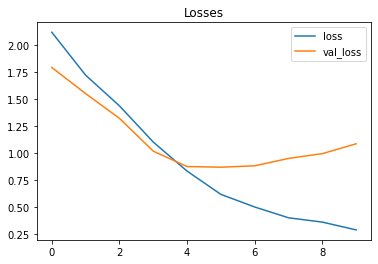

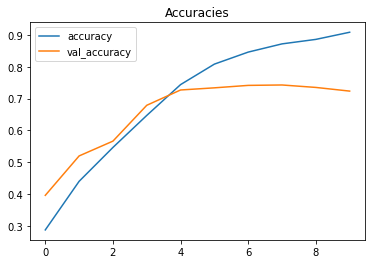

In [22]:
encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=sequence_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    pad_to_max_tokens=True
)
encoder.adapt(train_ds_orig.map(lambda text, label: text).batch(512))
# This model has 3 LSTM layers stacked

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

model = models.Sequential()
model.add(encoder)
model.add(layers.Embedding(input_dim=vocabulary_size, output_dim=32))
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
model.add(transformer_block)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(12, activation='softmax'))
model.summary()
model.compile(
    optimizer='adam', #<- one way
    #optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

render_history(history)